In [1]:
#Data Source:  https://www.kaggle.com/datasets/vencerlanz09/sea-animals-image-dataste

In [2]:
# Import necessary libraries
!pip install Pillow
!pip install scikit-image
import os
from PIL import Image
from skimage.feature import local_binary_pattern
import numpy as np
import pandas as pd
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.filters import prewitt_h, prewitt_v
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import joblib

In [3]:
#mount google drive to access files
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#define path to the image directory - UPDATED PATH
image_dir = '/content/drive/MyDrive/images_SeaAnimals'

# Check if the directory exists
if os.path.exists(image_dir):
    image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
    print("Files found:", image_files)
else:
    print("Error: Directory not found -", image_dir)


Files found: []


In [5]:
if os.path.exists(image_dir):
    # Get a list of class names (assuming subdirectories are class names)
    classes = [d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))]
    print("Classes found:", classes)
else:
    print("Error: Directory not found -", image_dir)

Classes found: ['Turtle_Tortoise', 'Sea Urchins', 'Squid', 'Shrimp', 'Sharks', 'Whale', 'Seahorse', 'Starfish', 'Sea Rays', 'Seal', 'Eel', 'Fish', 'Lobster', 'Otter', 'Puffers', 'Nudibranchs', 'Penguin', 'Octopus', 'Jelly Fish', 'Dolphin', 'Clams', 'Corals', 'Crabs']


In [6]:
data = []  # Initialize data as a list
for class_name in classes:
    class_path = os.path.join(image_dir, class_name)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)

        data.append({'image_path': image_path, 'class_label': class_name})  # Append dictionary to list

# Create DataFrame after the loop
data = pd.DataFrame(data)

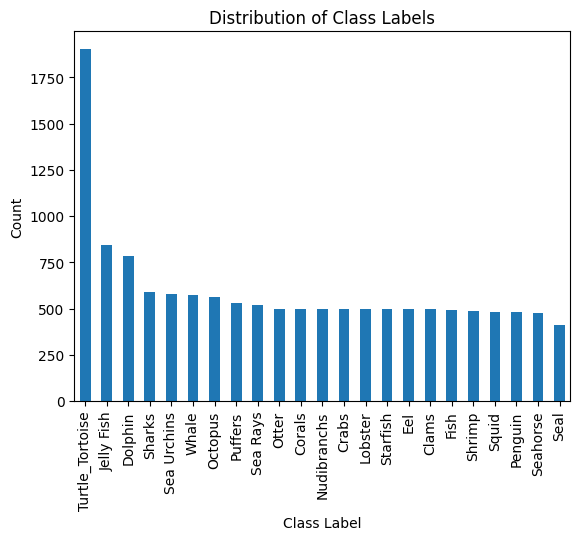

In [7]:
#Plotting the distribution of different image categories

data['class_label'].value_counts().plot(kind='bar')
plt.title('Distribution of Class Labels')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()


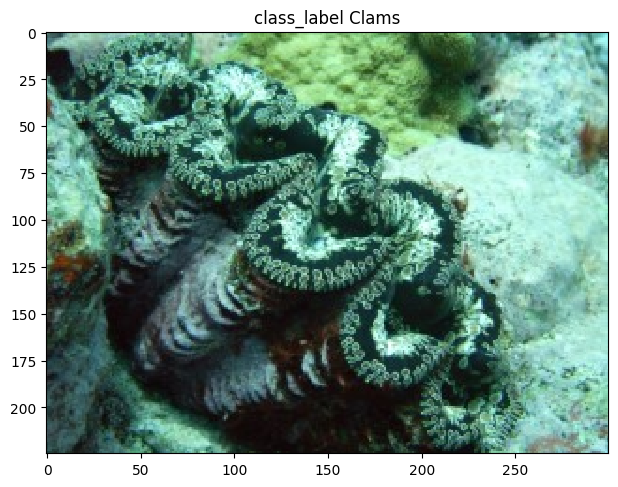

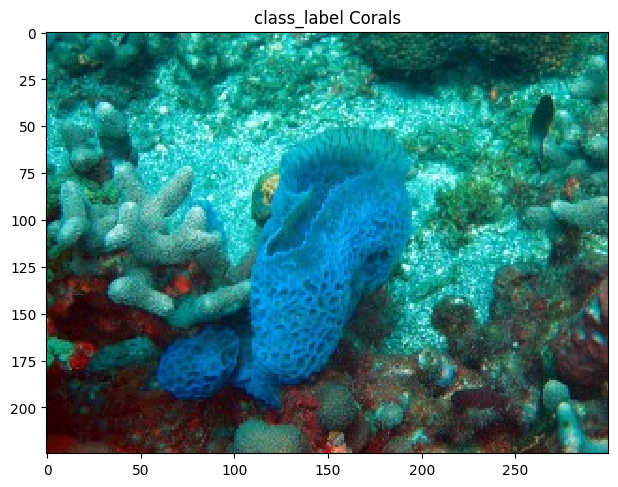

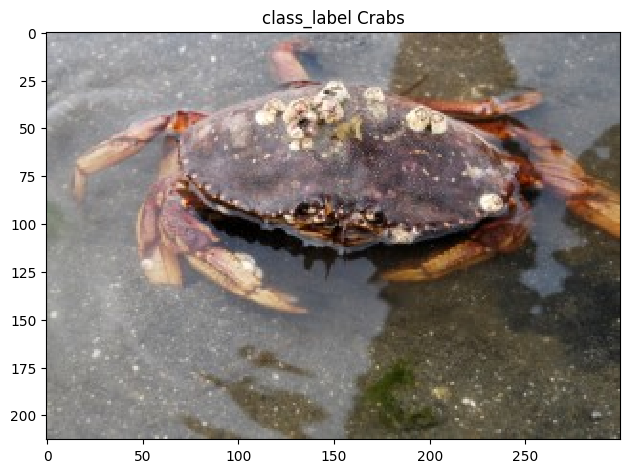

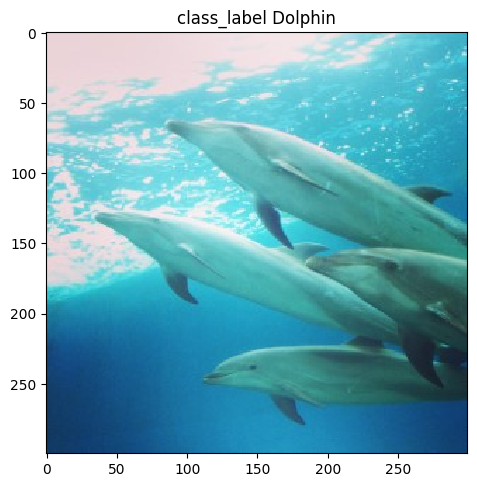

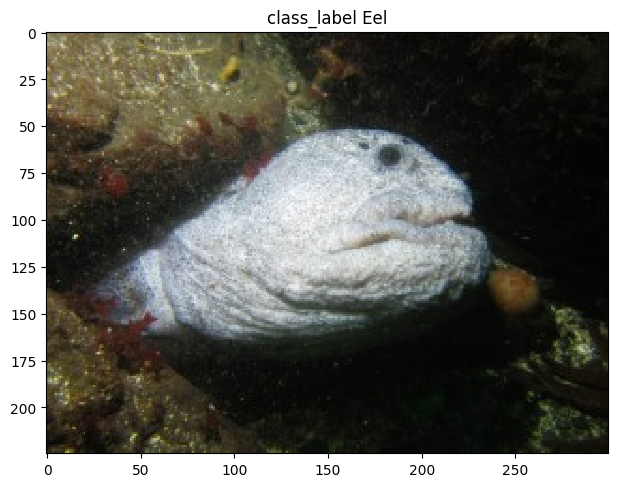

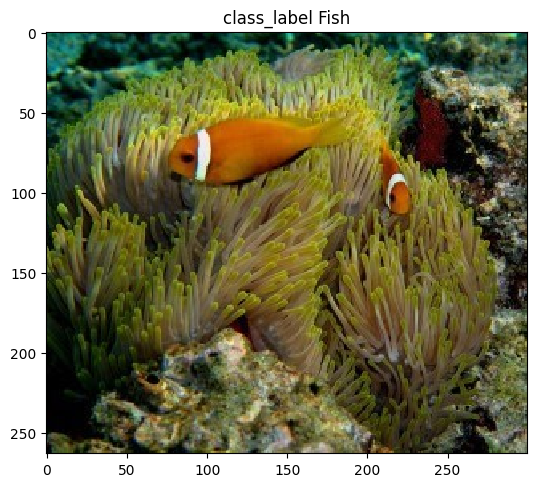

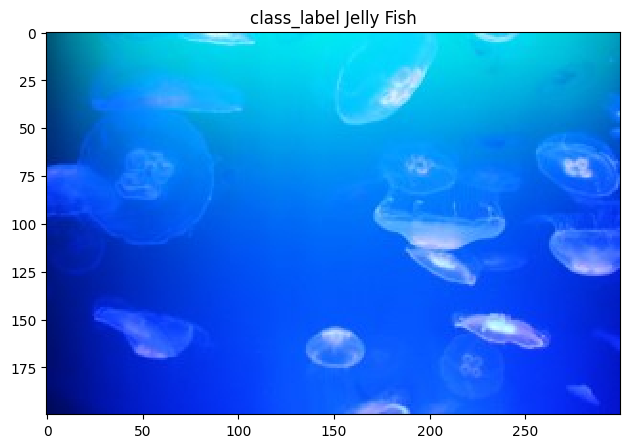

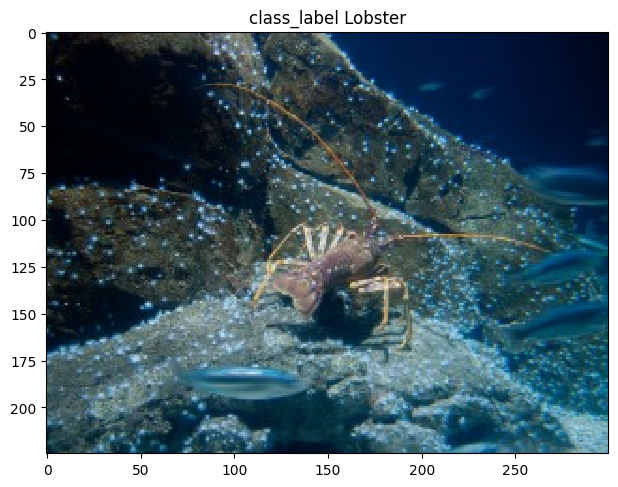

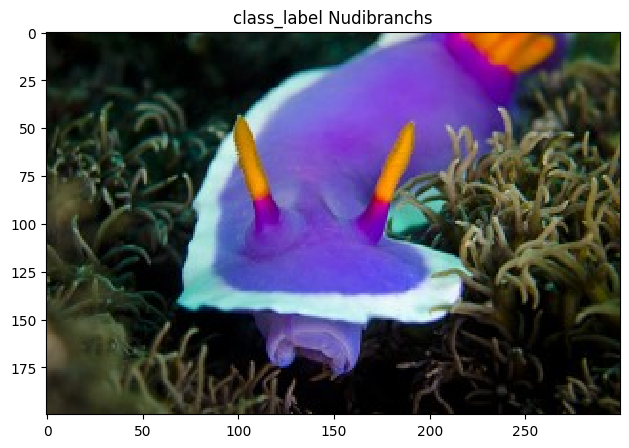

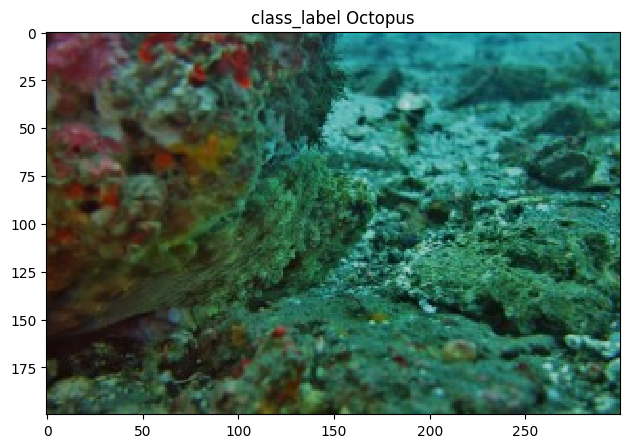

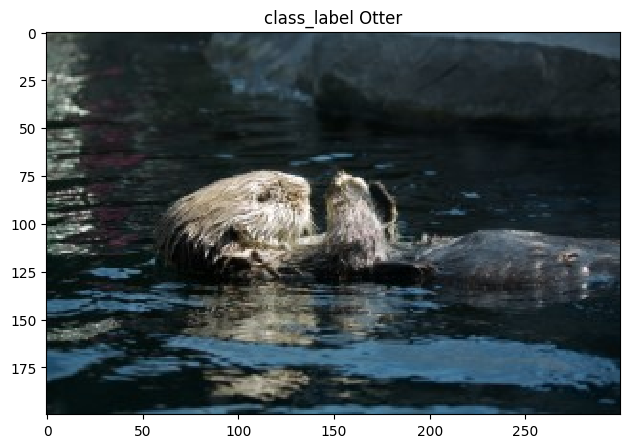

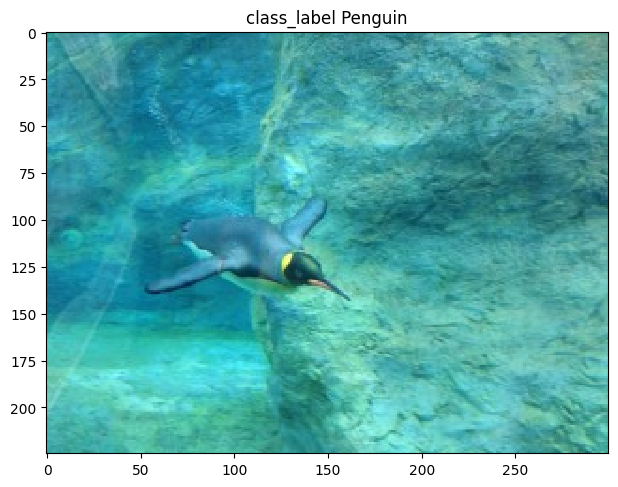

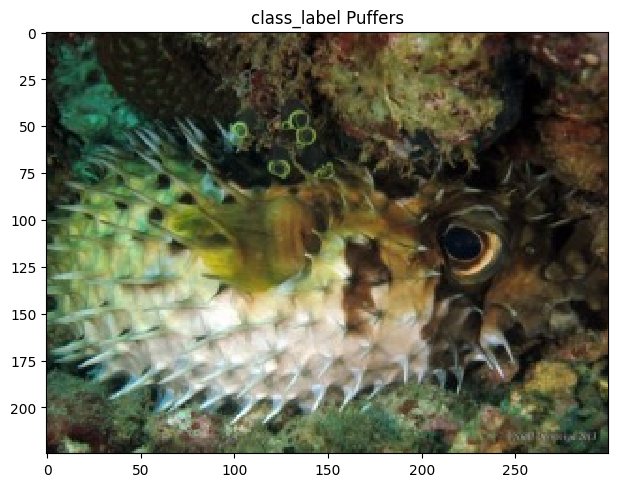

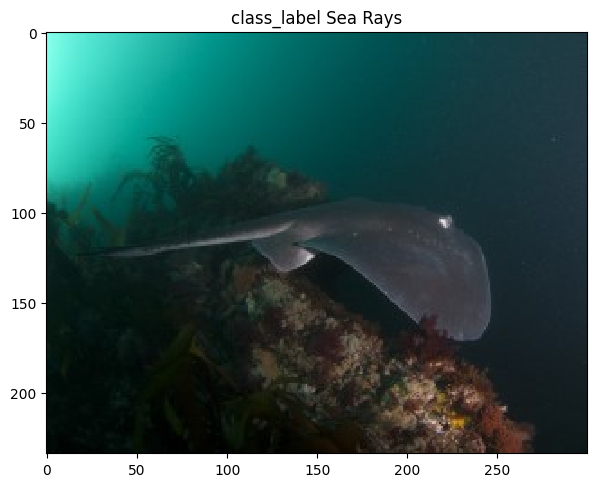

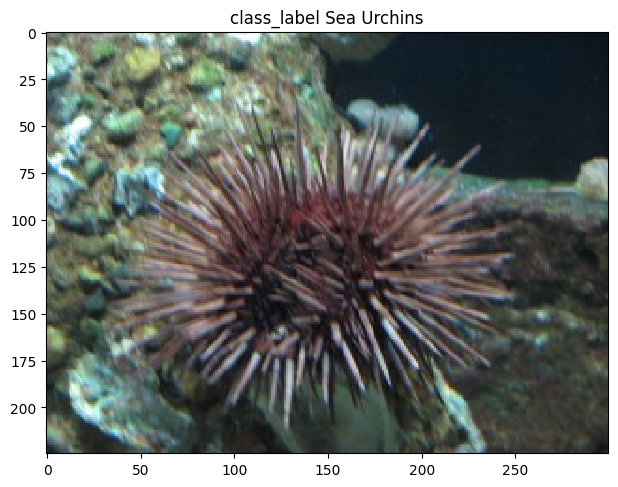

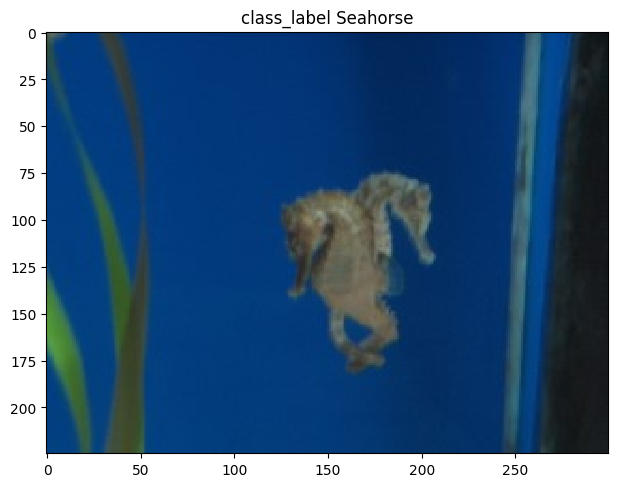

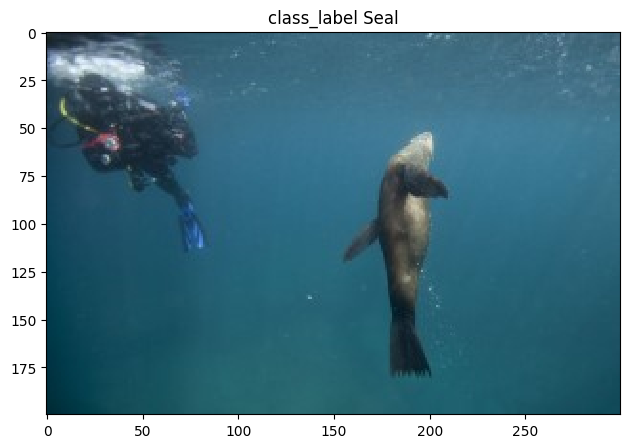

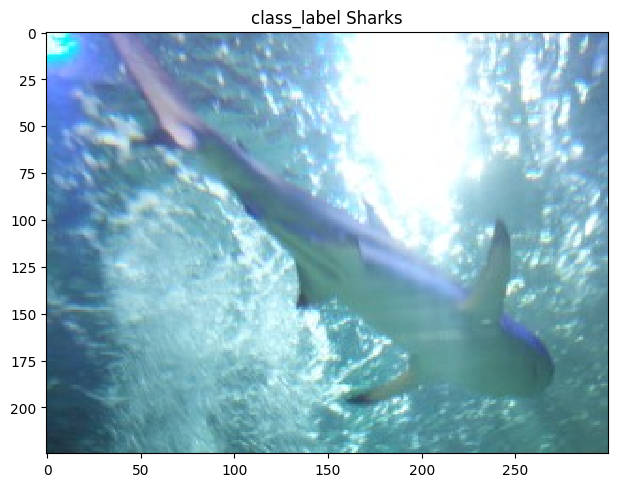

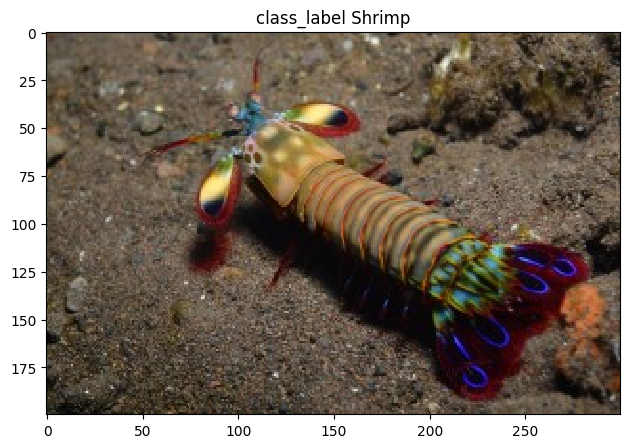

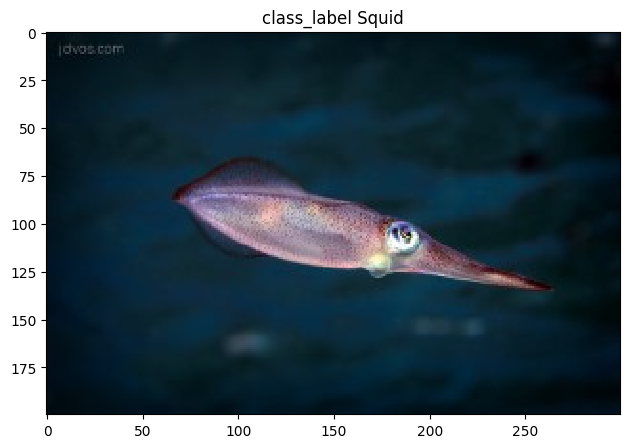

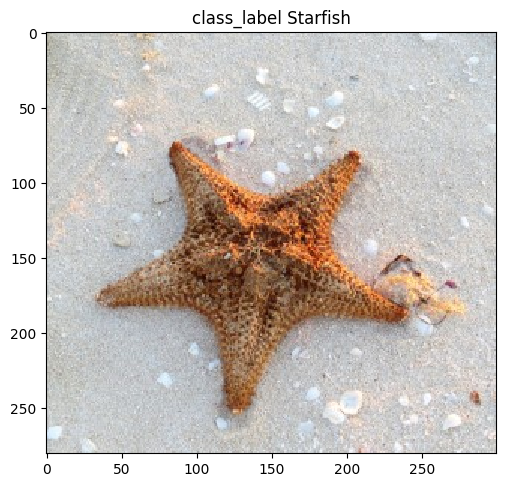

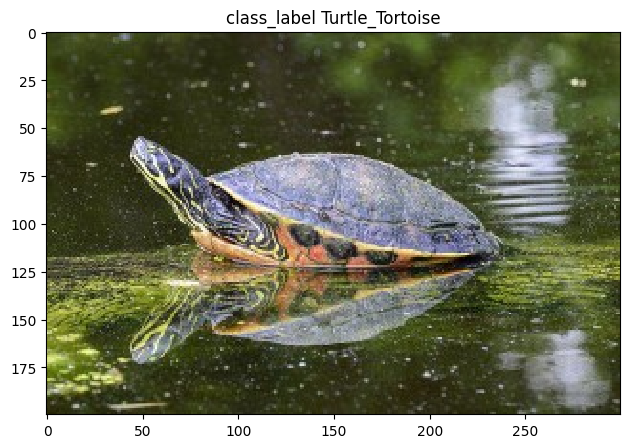

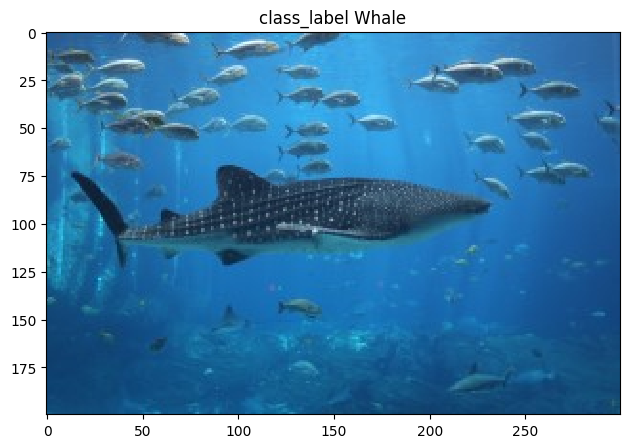

In [8]:
#Display sample images from each category
for cat in sorted(data['class_label'].unique()):
  sample_image_row = data[data['class_label'] == cat].iloc[0] # Get the entire row
  sample_image_path = sample_image_row['image_path'] # Access the 'image_path' column
  image = imread(sample_image_path)
  imshow(image)
  plt.title(f'class_label {cat}')
  plt.show()


In [9]:
# Define categories for analysis
categories = {
    'Whales vs Seals': data[(data['class_label'] == 'Whale') | (data['class_label'] == 'Seal')],
    'Starfish vs Jelly Fish': data[(data['class_label'] == 'Starfish') | (data['class_label'] == 'Jelly Fish')],
    'Turtle_tortoise vs Crabs': data[(data['class_label'] == 'Turtle_tortoise') | (data['class_label'] == 'Crabs')],
    'Penguin vs Whale': data[(data['class_label'] == 'Penguin') | (data['class_label'] == 'Whale')],
    'Puffers vs Whale': data[(data['class_label'] == 'Puffers') | (data['class_label'] == 'Whale')],
    'Sea Rays vs  Seahorse': data[(data['class_label'] == 'Sea Rays') | (data['class_label'] == 'Seahorse')],
}


# Process each category set for feature extraction and classification
for comparison, data in categories.items():
    print(f"Processing category: {comparison}")  # Print which category is being processed

    # Get list of image paths for the category
    image_list = data['image_path'].tolist()

    # Parameters for Local Binary Pattern (LBP) feature extraction
    METHOD = 'uniform'
    radius = 1
    n_points = 8 * radius

    all_features = []
    successful_paths = []

    # Loop through each image in the category
    for i, image_path in enumerate(image_list):
        print(f"Processing image {i+1} at path: {image_path}")  # Check if paths are correct
        try:
            image = Image.open(image_path)
            image = image.resize((100, 100))  # Resize image to 100x100 pixels
            image = np.array(image)  # Convert to NumPy array

            # Check if image has an alpha channel and remove it if present
            if image.shape[2] == 4:
                image = image[:, :, :3]  # Keep only first 3 channels (RGB)

            # Extract RGB features by averaging the pixel values
            rgb_feature_matrix = np.mean(image, axis=2)
            rgb_features = rgb_feature_matrix.flatten()  # Flatten to 1D array
            print("Shape of RGB features:", rgb_features.shape)

            # Convert image to grayscale for further feature extraction
            gray_image = rgb2gray(image)

            # Extract Local Binary Pattern features
            lbp_image = local_binary_pattern(gray_image, n_points, radius, METHOD)
            lbp_features = lbp_image.flatten()
            print("Shape of LBP features:", lbp_features.shape)

            # Extract horizontal and vertical edge features using Prewitt filters
            horizontal_edges = prewitt_h(gray_image).flatten()
            vertical_edges = prewitt_v(gray_image).flatten()

            print("Shape of horizontal edges:", horizontal_edges.shape)
            print("Shape of vertical edges:", vertical_edges.shape)

            # Combine all features into a single array
            features = np.concatenate([rgb_features, lbp_features, horizontal_edges, vertical_edges])
            all_features.append(features)  # Append features for each image
            successful_paths.append(image_path)  # Append successful image path
        except Exception as e:
            print(f"Error processing image {image_path}: {e}") # Catch any errors during extraction




Processing category: Whales vs Seals
Processing image 1 at path: /content/drive/MyDrive/images_SeaAnimals/Whale/10663738236_f748d81495_o.jpg
Shape of RGB features: (10000,)
Shape of LBP features: (10000,)
Shape of horizontal edges: (10000,)
Shape of vertical edges: (10000,)
Processing image 2 at path: /content/drive/MyDrive/images_SeaAnimals/Whale/10664201083_049a67ab9a_o.jpg


/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
Shape of horizontal edges: (10000,)
Shape of vertical edges: (10000,)
Processing image 1099 at path: /content/drive/MyDrive/images_SeaAnimals/Puffers/Puffers (9).jpg
Shape of RGB features: (10000,)
Shape of LBP features: (10000,)
Shape of horizontal edges: (10000,)
Shape of vertical edges: (10000,)
Processing image 1100 at path: /content/drive/MyDrive/images_SeaAnimals/Puffers/Puffers (27).jpg
Shape of RGB features: (10000,)
Shape of LBP features: (10000,)
Shape of horizontal edges: (10000,)
Shape of vertical edges: (10000,)
Processing image 1101 at path: /content/drive/MyDrive/images_SeaAnimals/Puffers/Puffers (4).jpg
Shape of RGB features: (10000,)
Shape of LBP features: (10000,)
Shape of horizontal edges: (10000,)
Shape of vertical edges: (10000,)
Processing image 1102 at path: /content/drive/MyDrive/images_SeaAnimals/Puffers/Puffers (28).jpg
Shape of RGB features: (10000,)
Shape of LBP features: (10000,)
Shape of horizontal edges: 

In [10]:
# Convert the list of features to a NumPy array (outside the loop)
if all_features: # Check if any features were extracted
        X = np.array(all_features)
        # Filter the DataFrame to keep only rows with successful images
        data_filtered = data[data['image_path'].isin(successful_paths)]
        y = data_filtered['class_label'].values

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (994, 40000)
Shape of y: (994,)


In [11]:
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20 , random_state=42)

    # Standardize the feature values
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)



In [12]:
# Define classifiers to use (remove extra indent here)
classifiers = {
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(n_neighbors=10),
    'Gaussian NB': GaussianNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Logistic Regression': LogisticRegression(random_state=0, max_iter=500, solver='lbfgs', multi_class='auto'),
    'SVM Linear': svm.SVC(kernel='linear', C=1, decision_function_shape='ovo', probability=True),
    'SVM RBF': svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo', probability=True),
    'SVM Polynomial': svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo', probability=True),
    'SVM Sigmoid': svm.SVC(kernel='sigmoid', C=1, decision_function_shape='ovo', probability=True)
}

    # Train each classifier and evaluate using cross-validation
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    cv = KFold(n_splits=5, random_state=1, shuffle=True)
    scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=cv)
    print(f'{name} CV Accuracy: {round(np.mean(scores) * 100, 2)} ± {round(np.std(scores) * 100, 2)}')

    # Predict on test set and print classification report
    y_pred = clf.predict(X_test)
    print(f'Classification Report for {name}')
    print(classification_report(y_test, y_pred,zero_division=1))
    print(f'Accuracy Score: {round(accuracy_score(y_test, y_pred) * 100, 2)}\n')

Decision Tree CV Accuracy: 63.65 ± 2.43
Classification Report for Decision Tree
              precision    recall  f1-score   support

    Sea Rays       0.69      0.70      0.69       105
    Seahorse       0.66      0.64      0.65        94

    accuracy                           0.67       199
   macro avg       0.67      0.67      0.67       199
weighted avg       0.67      0.67      0.67       199

Accuracy Score: 67.34

KNN CV Accuracy: 51.95 ± 3.74
Classification Report for KNN
              precision    recall  f1-score   support

    Sea Rays       0.53      1.00      0.69       105
    Seahorse       1.00      0.01      0.02        94

    accuracy                           0.53       199
   macro avg       0.77      0.51      0.36       199
weighted avg       0.75      0.53      0.38       199

Accuracy Score: 53.27

Gaussian NB CV Accuracy: 74.97 ± 0.92
Classification Report for Gaussian NB
              precision    recall  f1-score   support

    Sea Rays       0.76      

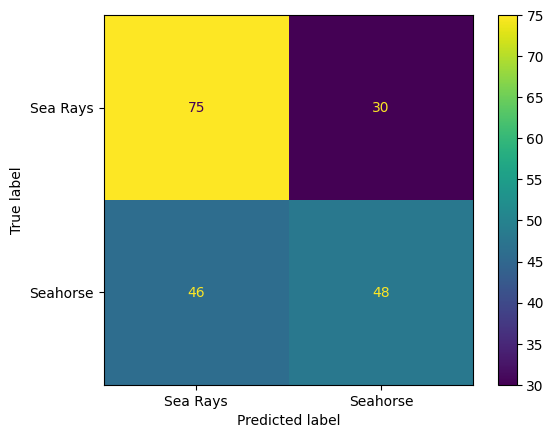

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

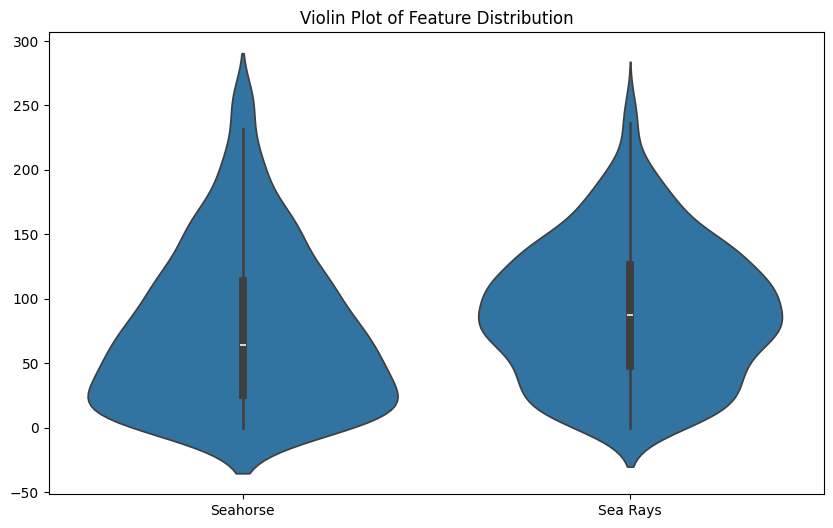

In [14]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.violinplot(x=y, y=X[:, 1]) # Replace 0 with the index of the feature you want to plot
plt.title("Violin Plot of Feature Distribution")
plt.show()

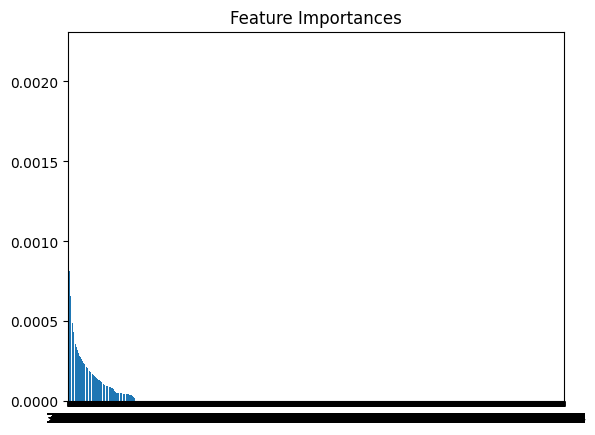

In [15]:
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train, y_train)

# Now extract feature importances from the Random Forest model
importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

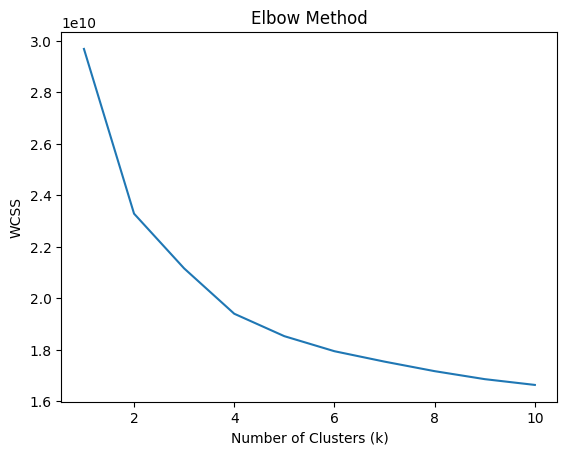

In [16]:
# prompt: generate a graph depicting the elbow of the K-Means algorithm

import matplotlib.pyplot as plt
# Calculate the within-cluster sum of squares (WCSS) for different values of k
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot the elbow method graph
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()



In [24]:


# StandardScaler
filename_scaler = 'image_classification_scaler.joblib'
joblib.dump(sc, filename_scaler)


GaussianNB_clf = GaussianNB()
GaussianNB_clf.fit(X_train, y_train)
# Save the model
model = GaussianNB_clf
joblib.dump(model, 'image_classification_gaussianNB.joblib')




['image_classification_gaussianNB.joblib']

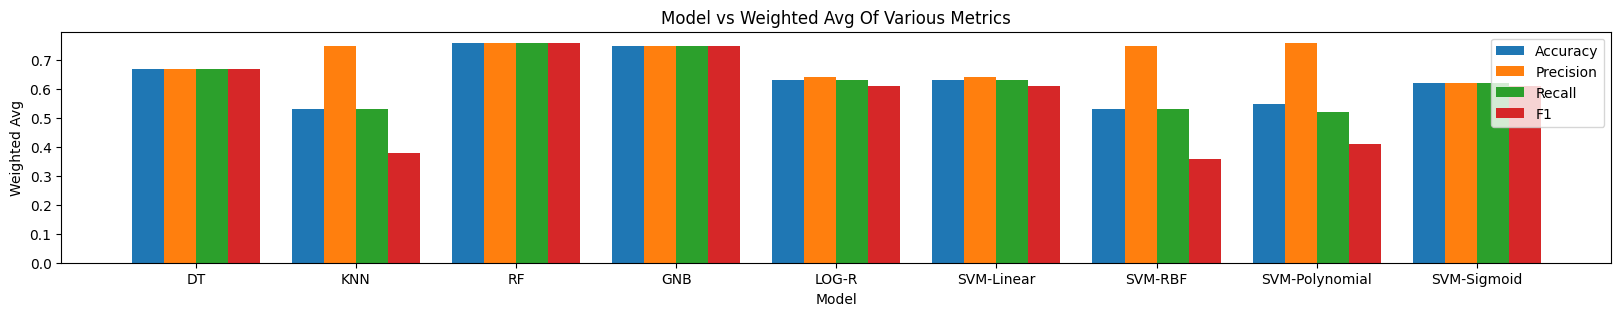

In [25]:
import numpy as np
import matplotlib.pyplot as plt

#Models
X = ['DT', 'KNN', 'RF', 'GNB', 'LOG-R', 'SVM-Linear', 'SVM-RBF', 'SVM-Polynomial', 'SVM-Sigmoid' ]

# Collect this information from the classification reports and store them in lists
accuracy = [0.67,0.53, 0.76, 0.75, 0.63, 0.63, 0.53, 0.55, 0.62]
precision = [0.67,0.75,0.76, 0.75, 0.64, 0.64, 0.75, 0.76, 0.62]
recall = [0.67, 0.53, 0.76, 0.75, 0.63, 0.63, 0.53, 0.52, 0.62]
f1 = [0.67, 0.38, 0.76, 0.75, 0.61, 0.61, 0.36, 0.41, 0.61]

# Number of bars
n_bars = len(X)

# Number of groups of bars (accuracy, precision, recall, f1)
n_groups = 4

# Total width for each group of bars
total_width = 0.8

# Width for each individual bar within a group
bar_width = total_width / n_groups

# Calculate the center positions for each group of bars
X_axis = np.arange(len(X))

# Calculate the left positions for each individual bar within a group
left_positions = X_axis - (total_width - bar_width) / 2

# Setting the size of the graph
plt.rcParams["figure.figsize"] = (20, 3)

# Plotting the bars for each metric using the left positions and respective data
plt.bar(left_positions, accuracy, bar_width, label='Accuracy')
plt.bar(left_positions + bar_width, precision, bar_width, label='Precision')
plt.bar(left_positions + bar_width * 2, recall, bar_width, label='Recall')
plt.bar(left_positions + bar_width * 3, f1, bar_width, label='F1')

# Setting the range of values for the X axis and labels
plt.xticks(X_axis, X)
plt.xlabel("Model")
plt.ylabel("Weighted Avg")
plt.title("Model vs Weighted Avg Of Various Metrics")
plt.legend(loc='upper right')

plt.show()